# ANHA4 sea-ice variability and its relation with d18O

This notebook summerized the calculation of ANHA4 sea-ice variability and the correspond change of d18O.

# Content
1. [**Import modules & tools**](#Import-modules-&-tools)
1. [**ANHA4-sea ice**](#ANHA4-sea-ice)
1. [**emps calculation**](#emps-calculation)
1. [**d18O experiments**](#d18O-experiments)

# Import modules & tools

In [1]:
import sys
sys.path.insert(0, '../../_libs/')

In [2]:
import glob
import scipy.io
import datetime
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [3]:
def monmean_3d(data):
    monmean=np.zeros([12, np.size(data, axis=1), np.size(data, axis=2)])
    for mon in range(12):
        monmean[mon, :, :] = np.nanmean(data[mon:len(data):12, :, :], 0)
    return monmean

# ANHA4 Sea-ice

In [4]:
ANHA4_MAT=scipy.io.loadmat('../../_data/Exchange/coord_ANHA4.mat')
nav_lat = ANHA4_MAT['nav_lat'].T
nav_lon = ANHA4_MAT['nav_lon'].T

In [5]:
ice_name = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/ileadfra_monmean.nc'
ice_obj = nc.Dataset(ice_name)
ice = ice_obj.variables['ileadfra'][:]
sss_name = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isssalin_monmean.nc'
sss_obj = nc.Dataset(sss_name)
sss = sss_obj.variables['isssalin'][:]

In [6]:
ice_monmean = monmean_3d(ice)

In [7]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

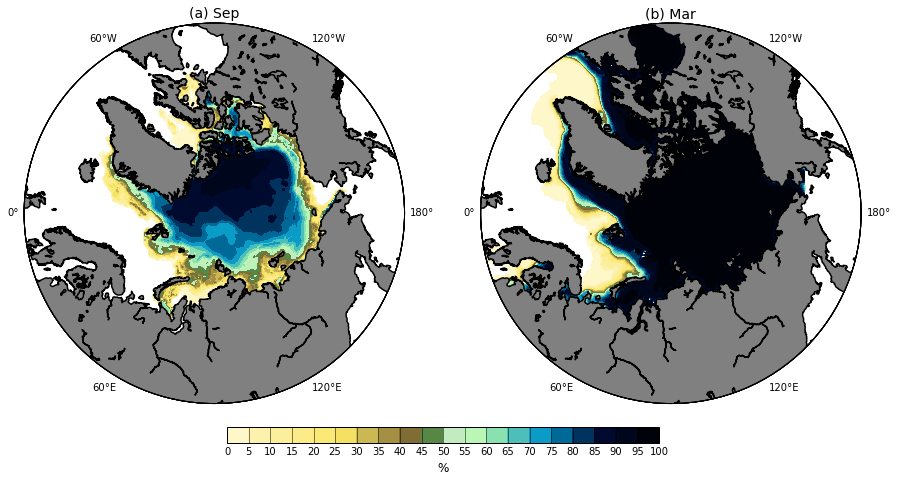

In [21]:
lev = np.arange(0, 105, 5)
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
#
proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax1)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='gray', lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(nav_lon, nav_lat)
CS=proj.contourf(x, y, ice_monmean[8, :, :]*100, lev, cmap=cm.GMT_relief_r)
ax1.set_title('(a) Sep', fontsize=14)
#
proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax2)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='gray', lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(nav_lon, nav_lat)
CS=proj.contourf(x, y, ice_monmean[2, :, :]*100, lev, cmap=cm.GMT_relief_r)
ax2.set_title('(b) Mar', fontsize=14)
#
cax  = fig.add_axes([0.313, 0.3, 0.4, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('%', fontsize=12)
CBar.ax.tick_params(axis='x', length=16)
CBar.set_ticks(lev)

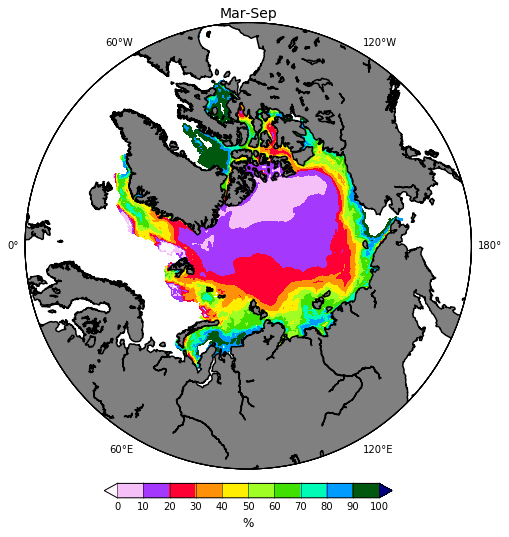

In [9]:
lev2 = np.arange(0, 110, 10)
fig=plt.figure(figsize=(8, 8));
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='gray', lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(nav_lon, nav_lat)
CS=proj.contourf(x, y, (ice_monmean[2, :, :]-ice_monmean[8, :, :])*100, lev2, cmap=plt.cm.gist_ncar_r, extend='both')
ax.set_title('Mar-Sep', fontsize=14)

cax = fig.add_axes([0.2625, 0.075, 0.5, 0.025])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('%', fontsize=12)
CBar.ax.tick_params(axis='x', length=16)
CBar.set_ticks(lev2)

In [10]:
ice_var = (ice_monmean[2, :, :]-ice_monmean[8, :, :])*100
#ice_var = ice_var.T

# emps calculation

In [11]:
safl_name = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/iocesafl_monmean.nc'
sss_name  = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isssalin_monmean.nc'
safl_obj = nc.Dataset(safl_name)
safl = safl_obj.variables['iocesafl'][:]
sss_obj = nc.Dataset(sss_name)
sss = sss_obj.variables['isssalin'][:]
emps=-1.0*safl*34.7/(3600.0*24*(sss+1.0e-16))

In [12]:
rf_name=glob.glob('../../_data/Samples/STN-30p/runoff_id_modified.mat')
rf_obj=scipy.io.loadmat(rf_name[0])
rf_id=rf_obj['rf_id']
rf_lon=rf_obj['lon']
rf_lat=rf_obj['lat']
rf_id[rf_id==2]=0 # 0 is Central Arctic

In [13]:
Class_interp = Nts.reporj_NEMOgrid(rf_lon, rf_lat, rf_id, nav_lon, nav_lat, method='nearest')
Class_range = Nts.reporj_NEMOgrid(rf_lon, rf_lat, rf_id, nav_lon, nav_lat, method='linear')
Class_interp[np.isnan(Class_range)] = np.nan

In [14]:
id1 = (ice_var>90)
id2 = (Class_interp==3)
id12 = np.logical_and(id1, id2)

/home/yingkai/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


# d18O experiments

In [15]:
lnum=0

FName_norf  = '/ocean/yingkai/GEOTRACES/Simulations/D18O01_1m_20020101_20041231_ptrc_T.nc'
FName_base = '/ocean/yingkai/GEOTRACES/Simulations/BASE03_1m_20020101_20131231_ptrc_T.nc'
FName_nodl  = '/ocean/yingkai/GEOTRACES/Simulations/BARIUM01_1m_20020101_20140103_ptrc_T.nc'

norf_obj = nc.Dataset(FName_norf)
base_obj = nc.Dataset(FName_base)
nodl_obj = nc.Dataset(FName_nodl)

nav_lon = base_obj.variables['nav_lon'][:]
nav_lat = base_obj.variables['nav_lat'][:]

d18O_norf = np.squeeze(norf_obj.variables['d18O'][:, lnum, :, :]); d18O_norf[d18O_norf==0]=np.nan
d18O_base = np.squeeze(base_obj.variables['d18O'][:, lnum, :, :]); d18O_base[d18O_base==0]=np.nan
d18O_nodl = np.squeeze(nodl_obj.variables['d18O'][:, lnum, :, :]); d18O_nodl[d18O_nodl==0]=np.nan

In [16]:
y_norf_all = np.nanmean(np.nanmean(d18O_norf, 1), 1)
y_nodl_all = np.nanmean(np.nanmean(d18O_nodl, 1), 1)
y_base_all = np.nanmean(np.nanmean(d18O_base, 1), 1)

/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [17]:
y_norf = np.nanmean(d18O_norf[:, id12], 1)
y_nodl = np.nanmean(d18O_nodl[:, id12], 1)
y_base = np.nanmean(d18O_base[:, id12], 1)
# reference variable
emps_baffin = np.nanmean(emps[:, id12], 1)
ice_baffin = np.nanmean(ice[:, id12], 1)
sss_baffin = np.nanmean(sss[:, id12], 1)

In [18]:
norf_stack  = np.reshape(y_norf,  [3, 12])
nodl_stack  = np.reshape(y_nodl, [12, 12])
base_stack = np.reshape(y_base, [12, 12])

emps_stack = np.reshape(emps_baffin, [12, 12])
#emps_stack_min = np.min(emps_stack, 0)
#emps_stack_mean = np.mean(emps_stack, 0)
#emps_stack_max = np.max(emps_stack, 0)

ice_stack = np.reshape(ice_baffin, [12, 12])
sss_stack = np.reshape(sss_baffin, [12, 12])
fake_x = range(1, 13)

**d18O seasonal cycle**

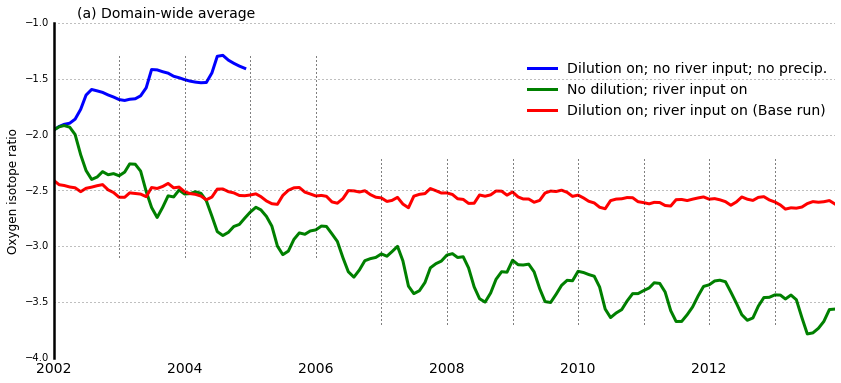

In [19]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca()

ax = fig.gca()
# grids
ax.grid(linestyle=':'); ax.xaxis.grid(False)
# axis
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
# label
ax.xaxis.set_tick_params(labelsize=14)
ax.set_ylabel('Oxygen isotope ratio', fontsize=12)
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")

ax.plot(date_list[:36], y_norf_all, lw=3, label='Dilution on; no river input; no precip.')
ax.plot(date_list, y_nodl_all, lw=3, label='No dilution; river input on')
ax.plot(date_list, y_base_all, lw=3, label='Dilution on; river input on (Base run)')
for i in range(12, 60, 12):
    ax.axvline(date_list[i], ymin=0.3, ymax=0.9, color='k', lw=1, ls=':')
for i in range(60, 144, 12):
    ax.axvline(date_list[i], ymin=0.1, ymax=0.6, color='k', lw=1, ls=':')
LG = ax.legend(numpoints=1, bbox_to_anchor=(0.6, 0.9), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)
ax.set_title("(a) Domain-wide average", x=0.03, loc='left', fontsize=14)

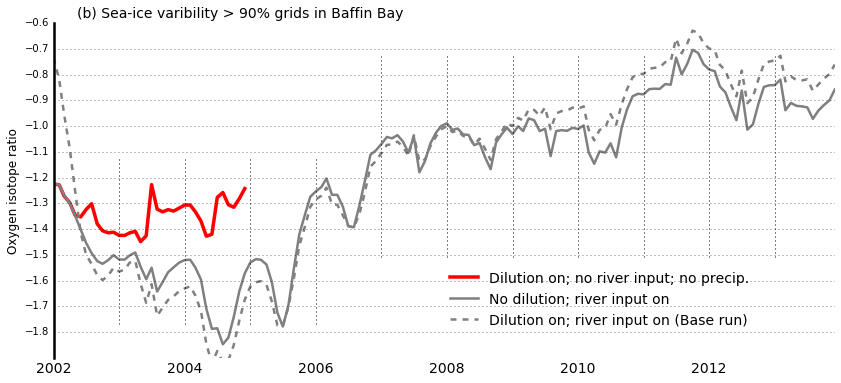

In [20]:
fig = plt.figure(figsize=(14, 6))

ax = fig.gca()
# grids
ax.grid(linestyle=':'); ax.xaxis.grid(False)
# axis
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim([date_list[0], date_list[143]])
ax.set_yticks(np.arange(-1.8, -0.6, 0.1)); ax.set_ylim([-1.9, -0.6])
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
# label
ax.xaxis.set_tick_params(labelsize=14)
ax.set_ylabel('Oxygen isotope ratio', fontsize=12)
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")
#
ax.plot(date_list[:36], y_norf[:36], 'r-', lw=3.5, label='Dilution on; no river input; no precip.');
ax.plot(date_list[:144], y_nodl[:144], color='gray', lw=2.5, label='No dilution; river input on');
ax.plot(date_list[:144], y_base[:144], '--', lw=2.5, color='gray', label='Dilution on; river input on (Base run)');
for i in range(12, 60, 12):
    ax.axvline(date_list[i], ymin=0.1, ymax=0.6, color='k', lw=1, ls=':')
for i in range(60, 144, 12):
    ax.axvline(date_list[i], ymin=0.3, ymax=0.9, color='k', lw=1, ls=':')
LG = ax.legend(numpoints=1, bbox_to_anchor=(0.5, 0.275), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)
ax.set_title("(b) Sea-ice varibility > 90% grids in Baffin Bay", x=0.03, loc='left', fontsize=14)

**Correspond emps**

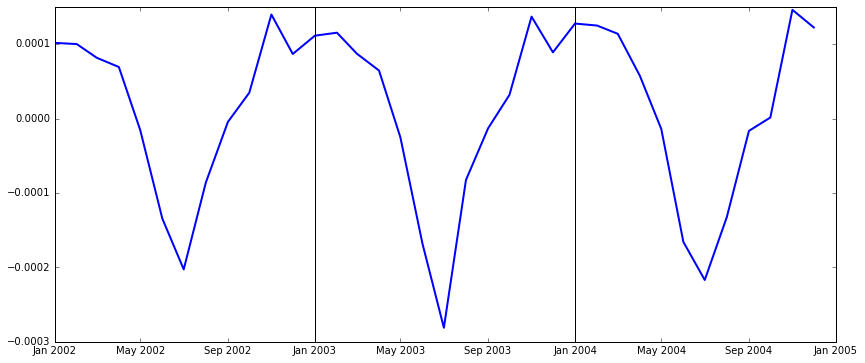

In [111]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca()
ax.set_xlim([date_list[0], date_list[36]])

ax.plot(date_list[:36], emps_baffin[:36], lw=2)
ax.axvline(date_list[12], color='k', lw=1)
ax.axvline(date_list[24], color='k', lw=1)

# Base run result

In [42]:
from numpy import *
from matplotlib.colors import LinearSegmentedColormap
class nlcmap(LinearSegmentedColormap):
    name = 'nlcmap'    
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = asarray(levels, dtype='float64')
        self._x = self.levels / self.levels.max()
        self._y = linspace(0.0, 1.0, len(self.levels))
    def __call__(self, xi, alpha=1.0, **kw):
        """docstring for fname"""
        yi = interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)

In [63]:
lev_d18O = np.array([-10, -5, -4, -3.5, -3, -2.5, -2, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5])

In [56]:
cmap_d18O = nlcmap(cm.s3pcpn_r, lev_d18O)

In [54]:
np.nanmin(d18O_base)

-22.785124

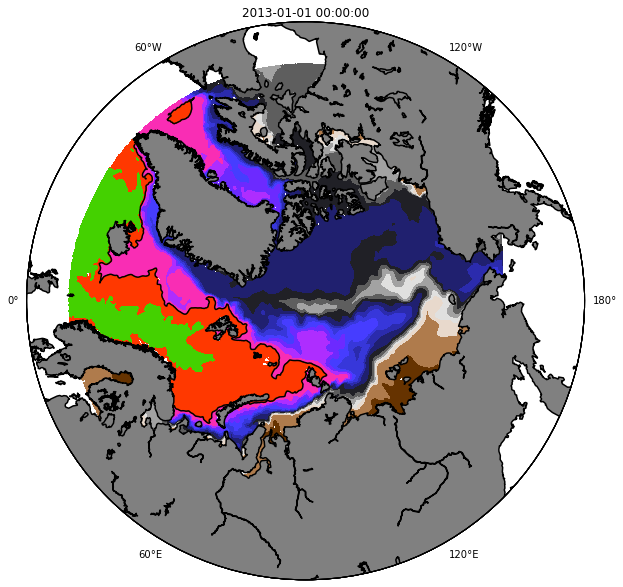

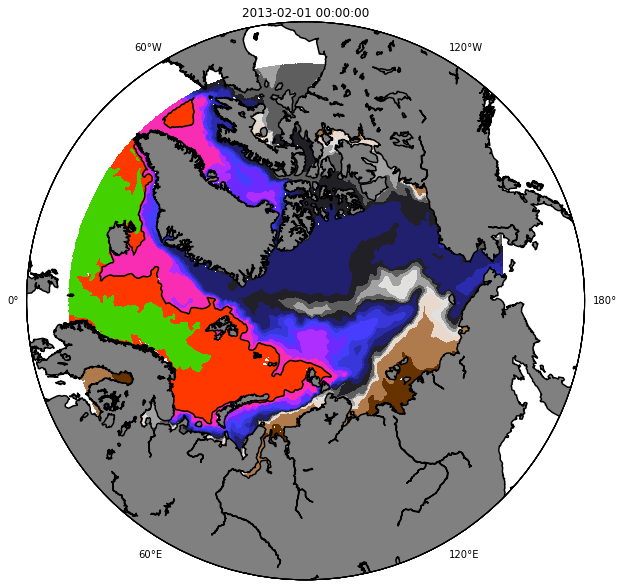

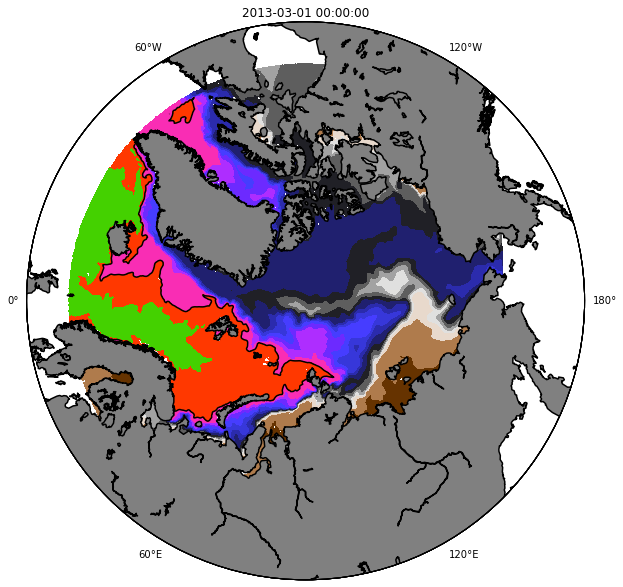

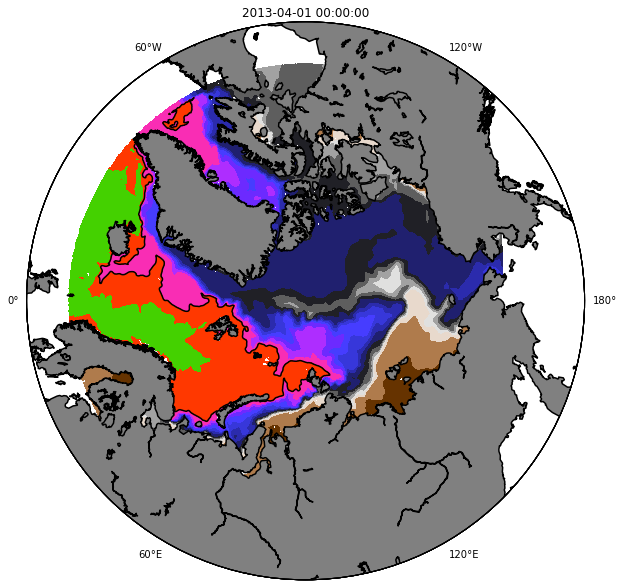

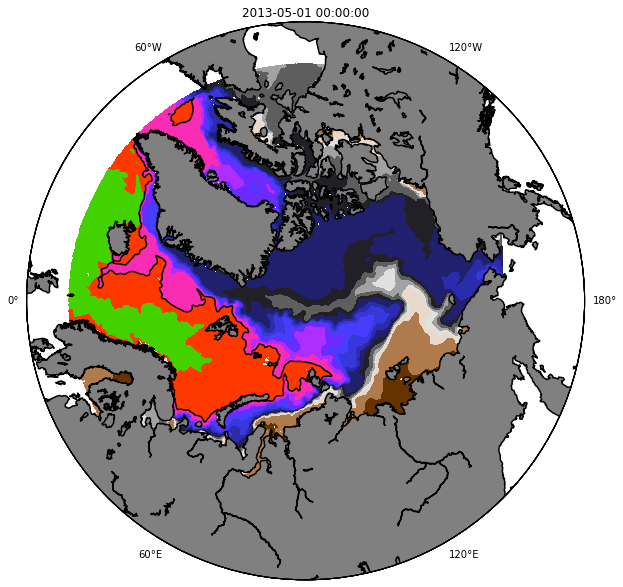

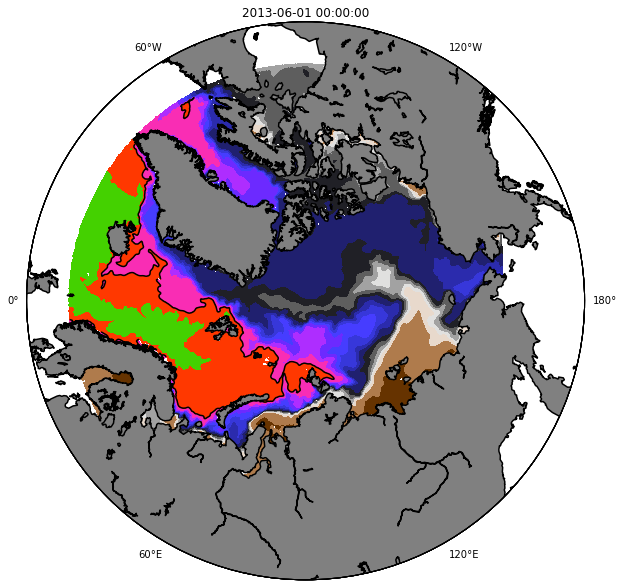

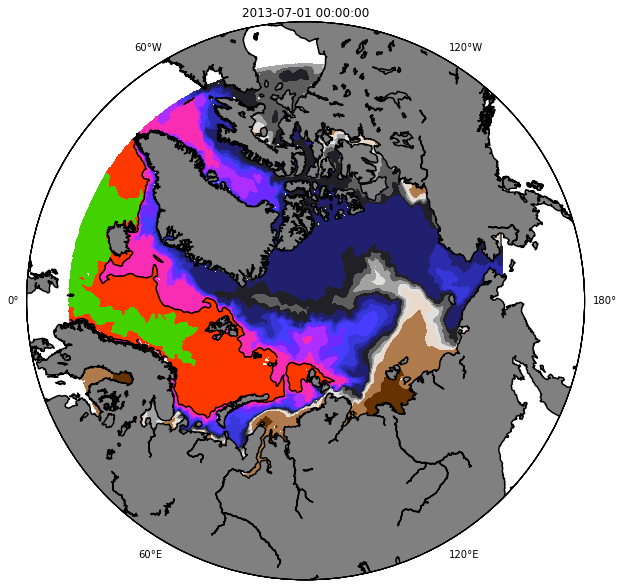

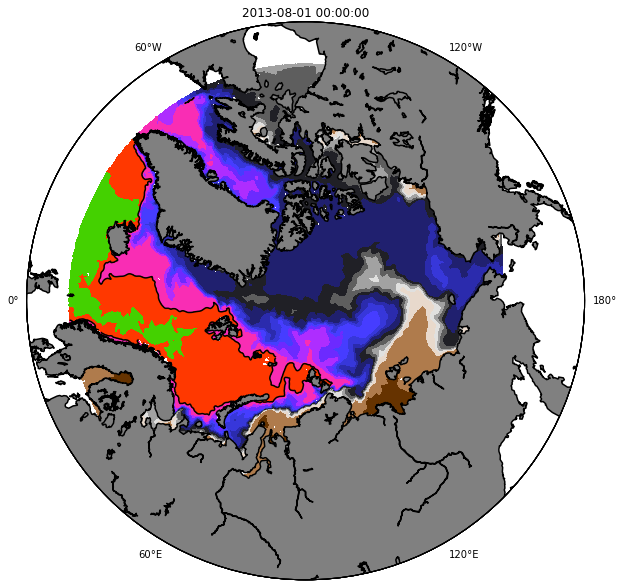

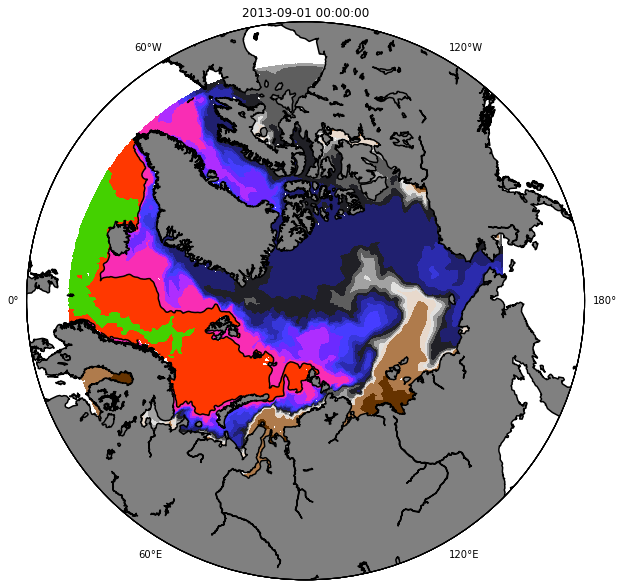

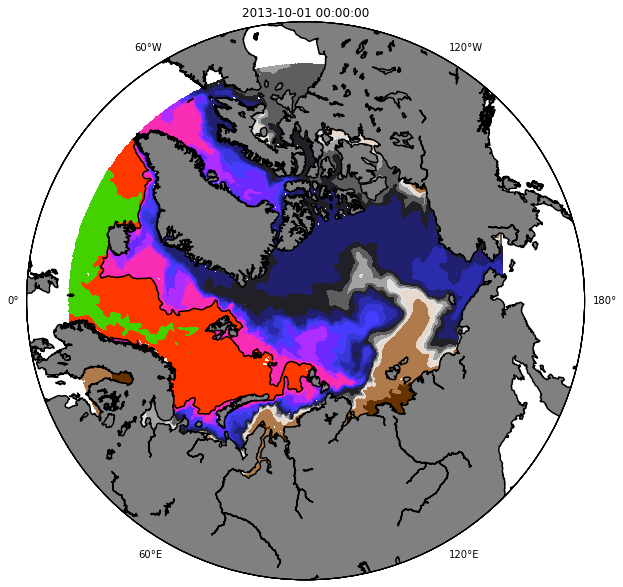

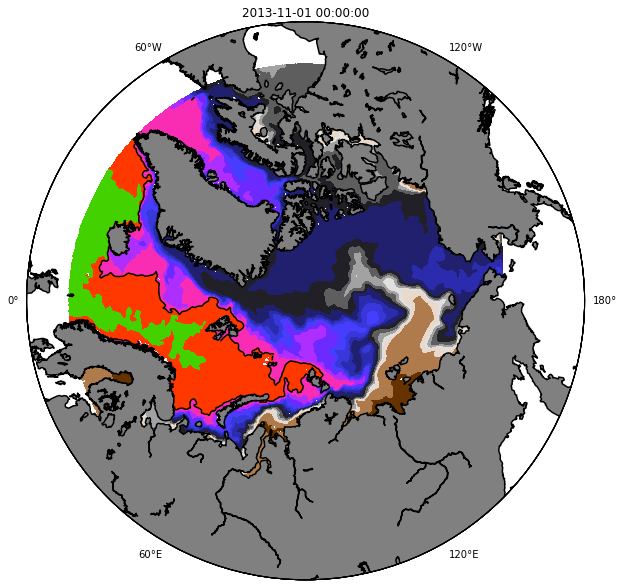

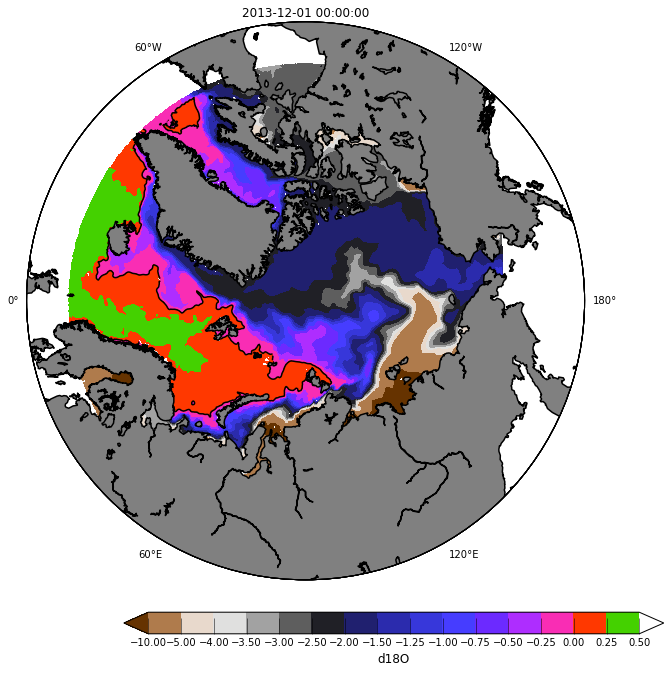

In [84]:
lev2 = np.arange(-13, 6, 1)
for i in range(132, 144):
    fig=plt.figure(figsize=(10, 10));
    ax = fig.gca()

    proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.5, color='k')
    x, y=proj(nav_lon, nav_lat)
    CS=proj.contourf(x, y, d18O_base[i, :, :], lev_d18O, cmap=cm.s3pcpn_r, extend='both')
    proj.contour(x, y, d18O_base[i, :, :], [0], linewidths=1.5, colors=('k',))
    ax.set_title(date_list[i])
    
cax = fig.add_axes([0.26, 0.05, 0.75, 0.03])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('d18O', fontsize=12)
CBar.ax.tick_params(axis='x', length=16)
CBar.set_ticks(lev_d18O)